In [2655]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, LassoCV, RidgeCV, Lasso
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from yellowbrick.regressor import ResidualsPlot
from scipy.stats import zscore
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading Data 

In [2656]:
df_mat = pd.read_csv('student-mat.csv', sep=';')
df_por = pd.read_csv('student-por.csv', sep=';')

df = pd.concat([df_mat, df_por])


In [2658]:
len(numerical_features+categorical_features+binary_features)

32

# Analysis

<AxesSubplot:xlabel='age', ylabel='G3'>

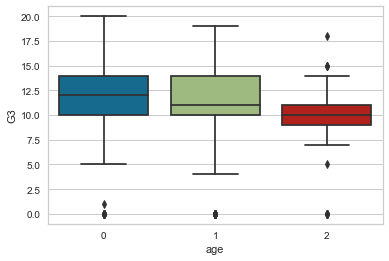

In [2659]:
def age(age):
    new_age=[]
    for i in age:
        if(i < 17):
            i=0
        elif (i < 19):
            i=1
        else:
            i=2
        new_age.append(i)
    return new_age

df['age']=age(df['age'])
sns.boxplot(x='age',y='G3',data=df)

<AxesSubplot:xlabel='absences', ylabel='G3'>

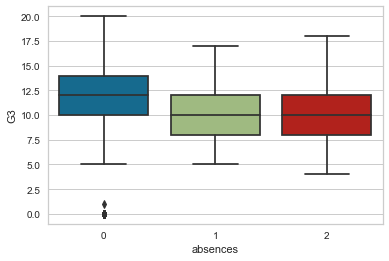

In [2660]:
def absences(n):
    new=[]
    for i in n:    
        if (i <= 10):
            i=0
        elif(i <= 20):
            i=1
        else:
            i=2
        new.append(i)
    return new

df['absences']=absences(df['absences'])
sns.boxplot('absences','G3',data=df)

# Correlations

<AxesSubplot:>

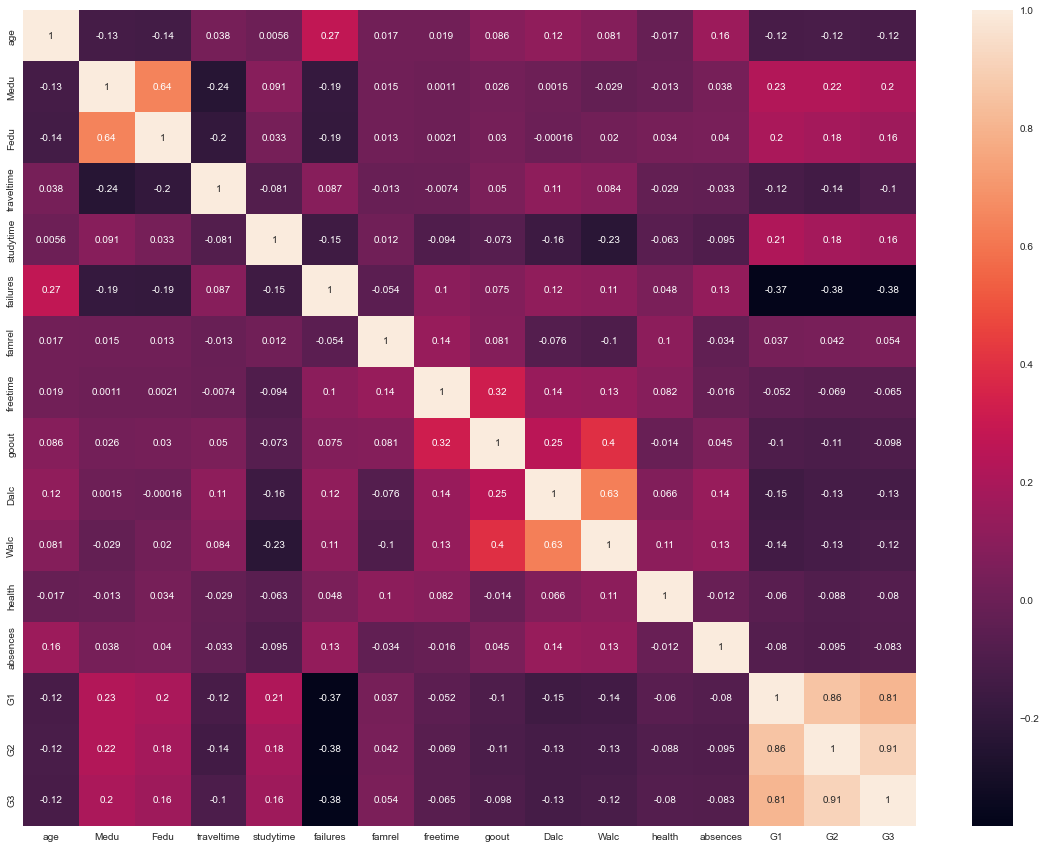

In [2661]:
# see correlation between variables through a correlation heatmap
corr = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True)

# Data Pipeline

In [2662]:
df[numerical_features] = MinMaxScaler().fit_transform(df[numerical_features])
# tmp = df[target]
# df = pd.get_dummies(df.drop([target], axis=1))

df = pd.get_dummies(df)
# df[target] = tmp

In [2663]:
df['final_G3'] = 'na'
# df.loc[(df.G3 >= 15) & (df.G3 <= 20), 'final_G3'] = 2 #'good' 
# df.loc[(df.G3 >= 10) & (df.G3 <= 14), 'final_G3'] = 1 #'fair' 
# df.loc[(df.G3 >= 0) & (df.G3 <= 9), 'final_G3'] = 0 #'poor' 
 
df.loc[(df.G3 >= 10) , 'final_G3'] = 1 #'Good' 
df.loc[(df.G3 <= 9), 'final_G3'] = 0 #'poor' 

df['final_G3'].value_counts(normalize=True)

1    0.779693
0    0.220307
Name: final_G3, dtype: float64

In [2664]:
# X = df.drop(['G3'], axis=1)
X = df.drop(['G1','G2','G3', 'final_G3'],axis=1)
y = df['final_G3'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ridge

In [2665]:
# definição da regressão por Ridge com alpha = 1
ridge_regr = Ridge(alpha=1)
score_ridge = cross_val_score(ridge_regr, X, y, cv=10, scoring="neg_mean_squared_error")
print(score_ridge.mean())


ridge_regr.fit(X_train,y_train)
y_pred  = ridge_regr.predict(X_test)
y_pred_train = ridge_regr.predict(X_train)

train_score=ridge_regr.score(X_train,y_train)
test_score=ridge_regr.score(X_test,y_test)
r2score = r2_score(y_test, y_pred)
coeff_used = np.sum(ridge_regr.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("R^2 score: ", r2score)
print("number of features used: ", coeff_used)

-0.15142309563536782
training score: 0.20899702070001258
test score:  0.14827430313533607
R^2 score:  0.14827430313533607
number of features used:  56


In [2666]:
pd.Series(ridge_regr.coef_, index = X_train.columns ).describe()

count    56.000000
mean     -0.011771
std       0.091238
min      -0.597721
25%      -0.020267
50%       0.002743
75%       0.022799
max       0.086357
dtype: float64

In [2667]:
pd.Series(ridge_regr.coef_, index = X_train.columns ).sort_values(ascending=False)[:coeff_used]

Mjob_health          0.086357
traveltime           0.083978
higher_yes           0.078848
paid_no              0.064923
school_GP            0.051676
schoolsup_no         0.040297
Dalc                 0.039617
Pstatus_A            0.039216
Fedu                 0.036329
famrel               0.035066
reason_reputation    0.033893
Fjob_teacher         0.028925
studytime            0.026792
Fjob_at_home         0.025945
nursery_no           0.021751
freetime             0.017514
guardian_father      0.014261
famsup_no            0.013800
guardian_other       0.013480
sex_F                0.013230
romantic_no          0.012053
famsize_LE3          0.011731
internet_yes         0.011351
address_U            0.010215
Fjob_other           0.009981
Walc                 0.006786
Mjob_services        0.006375
reason_other         0.004225
age                  0.001261
activities_yes       0.000762
activities_no       -0.000762
Medu                -0.009915
address_R           -0.010215
internet_n

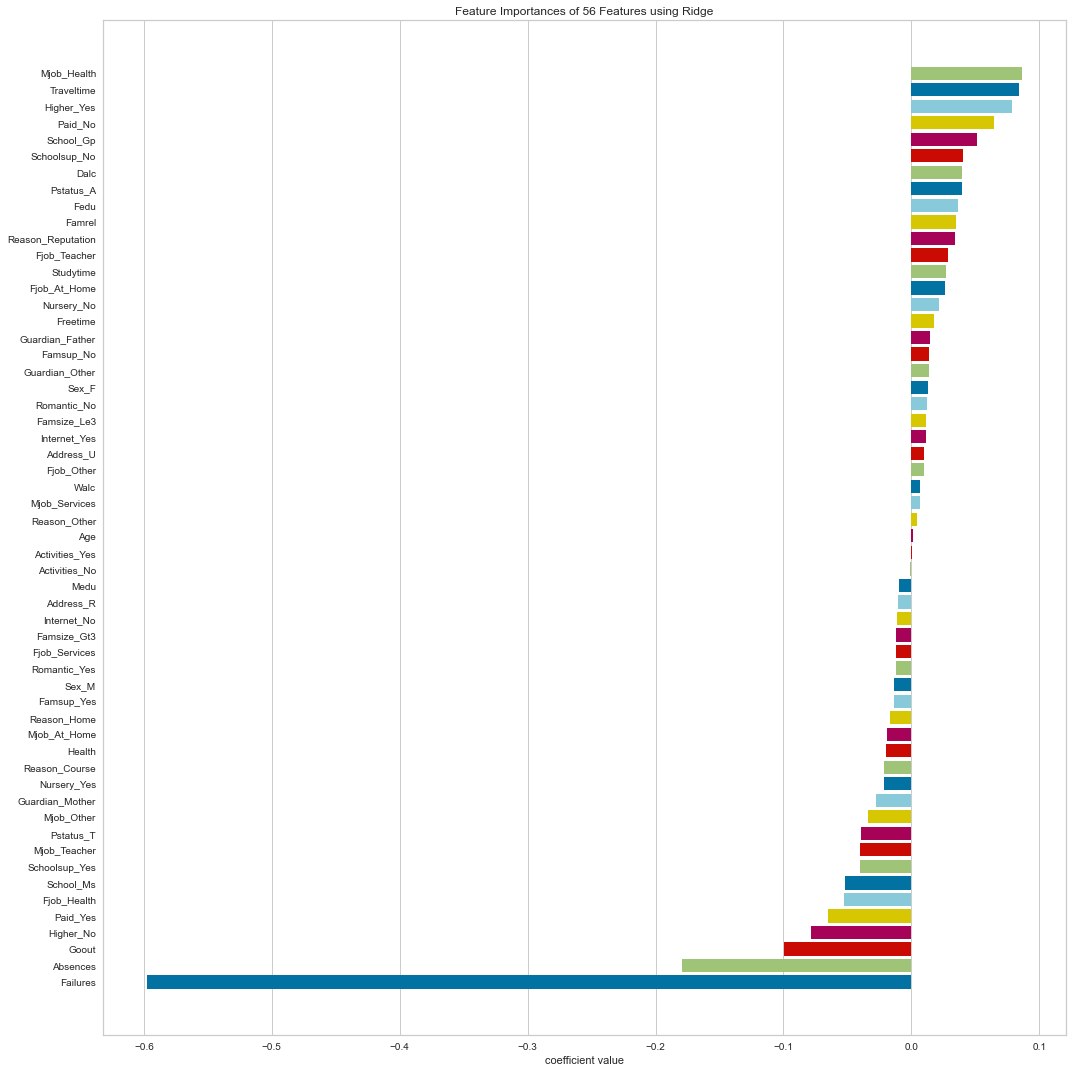

<AxesSubplot:title={'center':'Feature Importances of 56 Features using Ridge'}, xlabel='coefficient value'>

In [2668]:
from yellowbrick.model_selection import FeatureImportances
labels = list(map(lambda s: s.title(), X_train.columns ))
viz = FeatureImportances(ridge_regr, labels=labels, relative=False)
plt.figure(figsize=(15,15))
viz.fit(X_train, y_train)
viz.show()

In [2669]:
regr_ridgeCV = RidgeCV(cv=10)
score_ridge = cross_val_score(regr_ridgeCV, X, y, cv=10, scoring="neg_mean_squared_error")
print(score_ridge.mean())


regr_ridgeCV.fit(X_train,y_train)
y_pred  = regr_ridgeCV.predict(X_test)
y_pred_train = regr_ridgeCV.predict(X_train)

train_score=regr_ridgeCV.score(X_train,y_train)
test_score=regr_ridgeCV.score(X_test,y_test)
r2score = r2_score(y_test, y_pred)
coeff_used = np.sum(regr_ridgeCV.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("R^2 score: ", r2score)
print("number of features used: ", coeff_used)

-0.15145884740574767
training score: 0.20339268864259263
test score:  0.15547776062254348
R^2 score:  0.15547776062254348
number of features used:  56


In [2670]:
pd.Series(regr_ridgeCV.coef_, index = X_train.columns ).describe()

count    56.000000
mean     -0.009621
std       0.073587
min      -0.466399
25%      -0.019446
50%       0.001633
75%       0.020779
max       0.083424
dtype: float64

In [2671]:
pd.Series(regr_ridgeCV.coef_, index = X_train.columns ).sort_values(ascending=False)[:coeff_used]

higher_yes           0.083424
Mjob_health          0.071680
traveltime           0.064301
paid_no              0.062898
school_GP            0.047331
schoolsup_no         0.041006
Pstatus_A            0.036677
Fedu                 0.034663
reason_reputation    0.033826
studytime            0.032559
famrel               0.030878
Fjob_teacher         0.024748
Dalc                 0.023570
nursery_no           0.020792
guardian_father      0.020774
Fjob_at_home         0.016673
romantic_no          0.014374
famsup_no            0.013483
sex_F                0.013028
famsize_LE3          0.012549
internet_yes         0.011977
Fjob_other           0.011223
address_U            0.010333
freetime             0.006145
reason_other         0.005957
Mjob_services        0.003111
Medu                 0.002418
guardian_other       0.001908
activities_yes       0.001358
Walc                -0.000210
activities_no       -0.001358
address_R           -0.010333
internet_no         -0.011977
famsize_GT

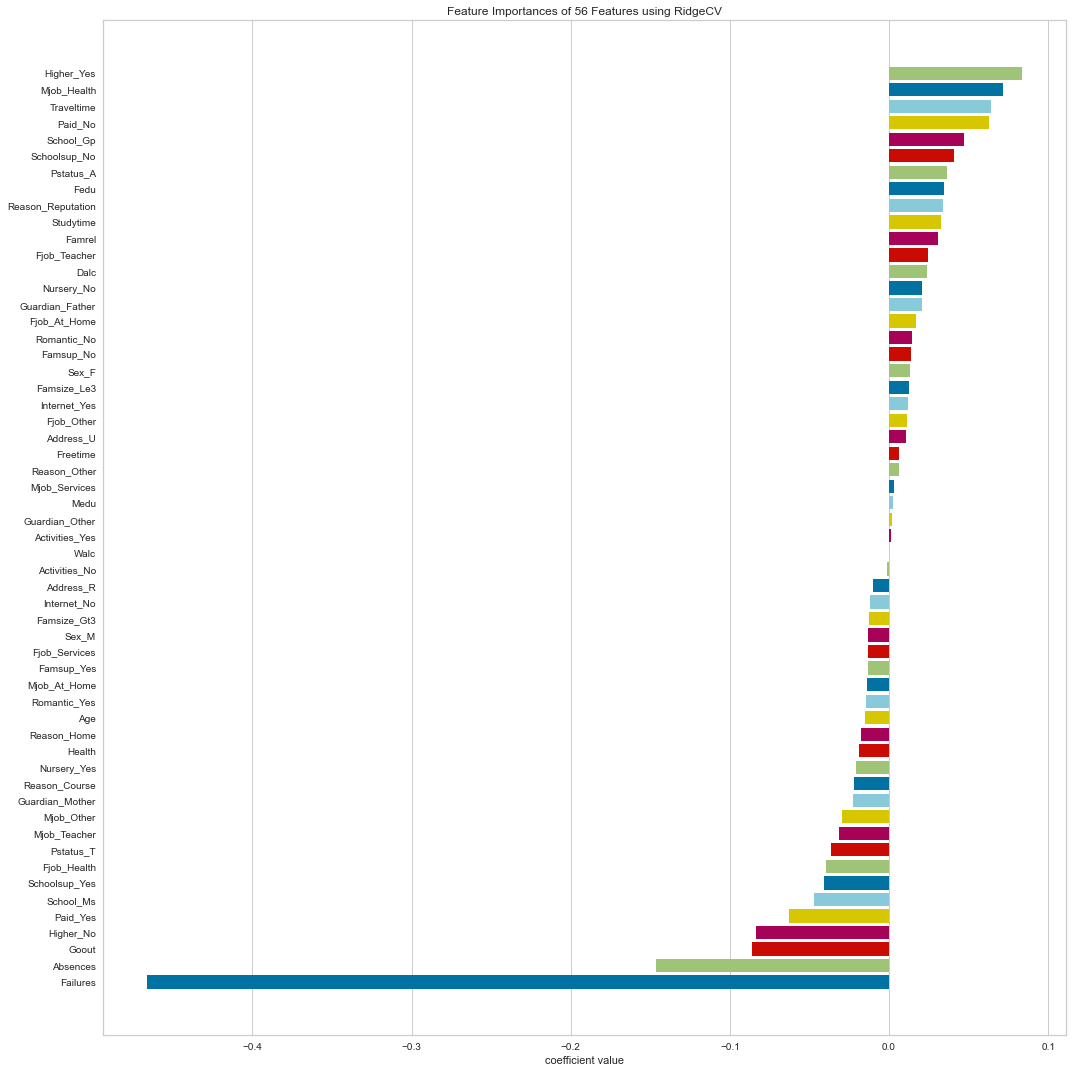

<AxesSubplot:title={'center':'Feature Importances of 56 Features using RidgeCV'}, xlabel='coefficient value'>

In [2672]:
labels = list(map(lambda s: s.title(), X_train.columns ))
viz = FeatureImportances(regr_ridgeCV, labels=labels, relative=False)
plt.figure(figsize=(15,15))
viz.fit(X_train, y_train)
viz.show()

# Lasso

In [2673]:
# definição da regressão de Lasso com alpha = 0.1
lasso_regr = Lasso(0.1)
score_lasso = cross_val_score(lasso_regr, X, y, cv=10, scoring="neg_mean_squared_error")
print(score_lasso.mean())

lasso_regr.fit(X_train,y_train)
y_pred  = lasso_regr.predict(X_test)
y_pred_train = lasso_regr.predict(X_train)

lasso_regr.fit(X_train,y_train)
train_score=lasso_regr.score(X_train,y_train)
test_score=lasso_regr.score(X_test,y_test)
r2score = r2_score(y_test, y_pred)
coeff_used = np.sum(lasso_regr.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("R^2 score: ", r2score)
print("number of features used: ", coeff_used)

-0.17479841789667044
training score: 0.0
test score:  -0.00018761832704639048
R^2 score:  -0.00018761832704639048
number of features used:  0


In [2674]:
pd.Series(lasso_regr.coef_, index = X_train.columns ).describe()

count    56.0
mean      0.0
std       0.0
min      -0.0
25%       0.0
50%      -0.0
75%       0.0
max      -0.0
dtype: float64

In [2675]:
pd.Series(lasso_regr.coef_, index = X_train.columns ).sort_values(ascending=False)[:coeff_used]

Series([], dtype: float64)

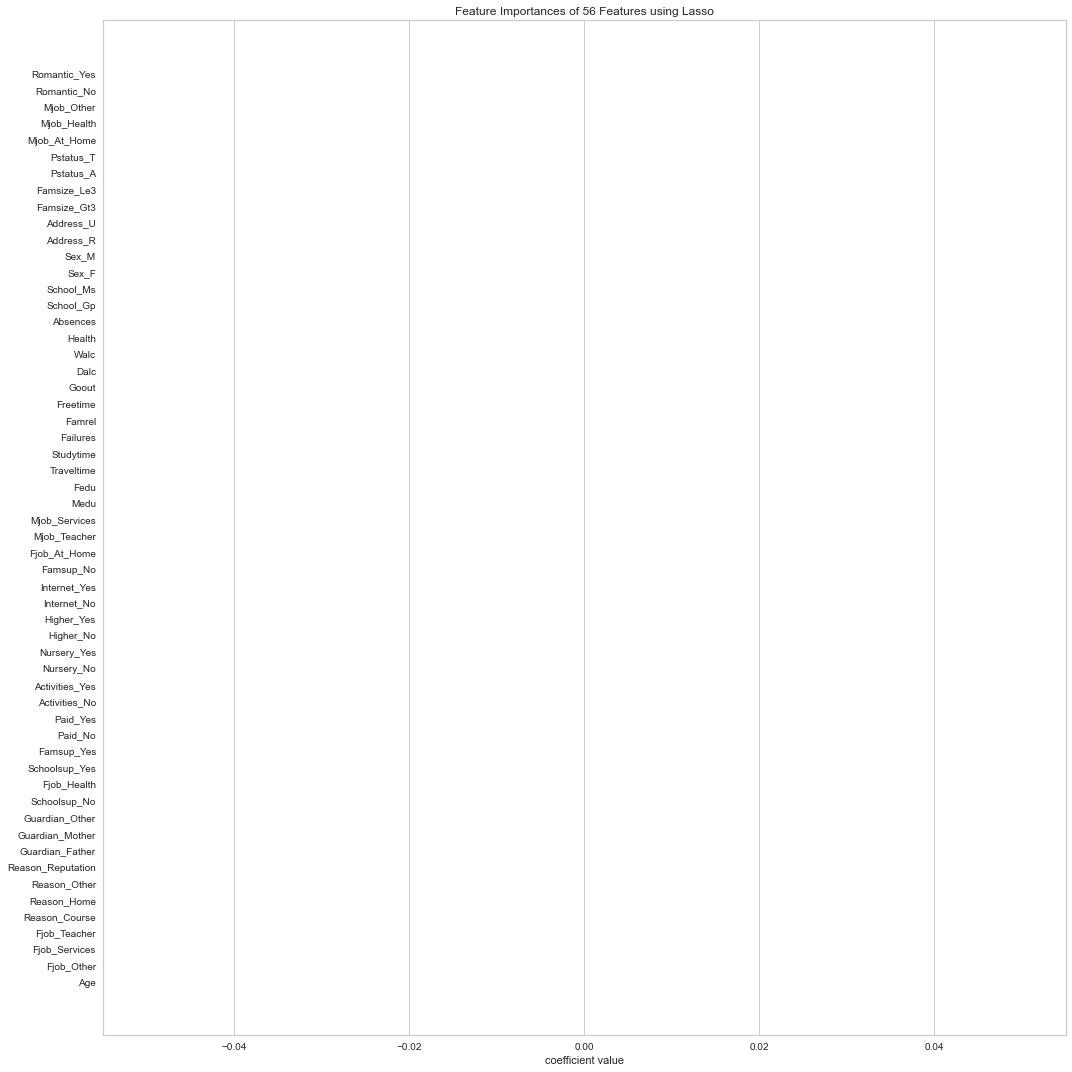

<AxesSubplot:title={'center':'Feature Importances of 56 Features using Lasso'}, xlabel='coefficient value'>

In [2676]:
labels = list(map(lambda s: s.title(), X_train.columns ))
viz = FeatureImportances(lasso_regr, labels=labels, relative=False)
plt.figure(figsize=(15,15))
viz.fit(X_train, y_train)
viz.show()

In [2677]:
regr_lassoCV = LassoCV(cv=10, eps=1e-4)
score_lasso = cross_val_score(regr_lassoCV, X, y, cv=10, scoring="neg_mean_squared_error")
print(score_lasso.mean())

regr_lassoCV.fit(X_train,y_train)
y_pred  = regr_lassoCV.predict(X_test)
y_pred_train = regr_lassoCV.predict(X_train)

regr_lassoCV.fit(X_train,y_train)
train_score=regr_lassoCV.score(X_train,y_train)
test_score=regr_lassoCV.score(X_test,y_test)
r2score = r2_score(y_test, y_pred)
coeff_used = np.sum(regr_lassoCV.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("R^2 score: ", r2score)
print("number of features used: ", coeff_used)

-0.1491941557964449
training score: 0.1943303072494591
test score:  0.150959839651592
R^2 score:  0.150959839651592
number of features used:  28


In [2678]:
pd.Series(regr_lassoCV.coef_, index = X_train.columns ).describe()

count    5.600000e+01
mean    -8.693442e-03
std      8.369516e-02
min     -5.775176e-01
25%     -6.871822e-19
50%     -0.000000e+00
75%      6.413256e-19
max      1.095926e-01
dtype: float64

In [2679]:
pd.Series(regr_lassoCV.coef_, index = X_train.columns ).sort_values(ascending=False)[:coeff_used]

paid_no              1.095926e-01
school_GP            7.554439e-02
Mjob_health          5.036474e-02
Pstatus_A            4.566720e-02
reason_reputation    4.530990e-02
schoolsup_no         3.789445e-02
nursery_no           2.203401e-02
famsup_no            1.034897e-02
romantic_no          8.286151e-03
Mjob_services        6.272230e-03
sex_F                9.051330e-04
traveltime           6.382549e-04
address_U            4.030125e-17
famsize_LE3          2.565303e-18
reason_course       -0.000000e+00
reason_other         0.000000e+00
Fjob_teacher         0.000000e+00
reason_home         -0.000000e+00
age                 -0.000000e+00
guardian_father      0.000000e+00
guardian_other       0.000000e+00
Fjob_other           0.000000e+00
paid_yes            -0.000000e+00
activities_no       -0.000000e+00
activities_yes       0.000000e+00
nursery_yes         -0.000000e+00
higher_yes           0.000000e+00
internet_yes         0.000000e+00
dtype: float64

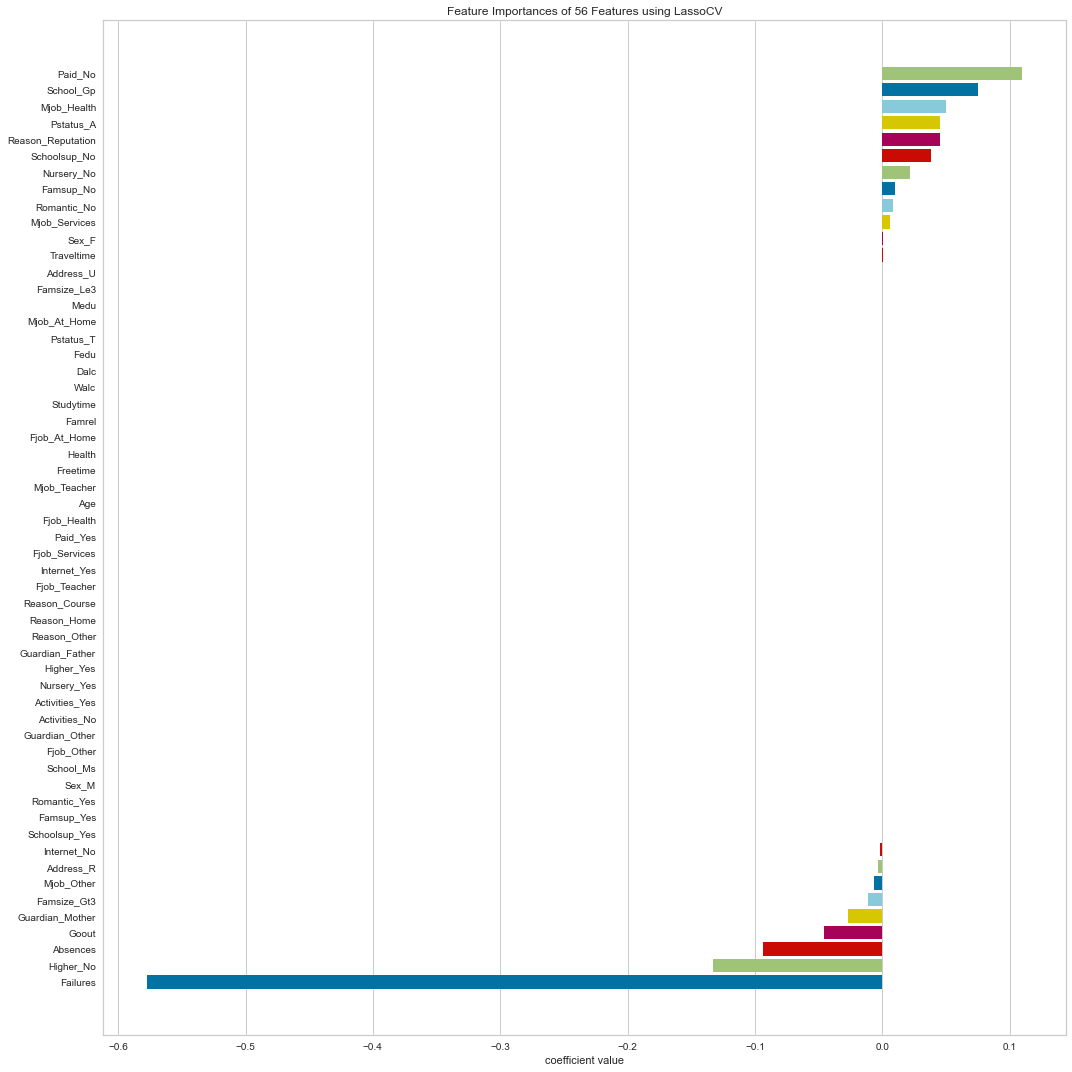

<AxesSubplot:title={'center':'Feature Importances of 56 Features using LassoCV'}, xlabel='coefficient value'>

In [2680]:
labels = list(map(lambda s: s.title(), X_train.columns ))
viz = FeatureImportances(regr_lassoCV, labels=labels, relative=False)
plt.figure(figsize=(15,15))
viz.fit(X_train, y_train)
viz.show()

# Logistic Regression

In [2681]:
model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.784688995215311

In [2682]:
y_pred  = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [2683]:
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)

In [2684]:
print(train_score, test_score)

0.8047904191616766 0.784688995215311


In [2685]:
accuracy_score(y_pred, y_test)

0.784688995215311

In [2686]:
accuracy_score(y_pred_train, y_train)

0.8047904191616766

In [2687]:
# target_names = ['Good', 'Fair', 'Poor']
print("Logistic Regression")
# print(classification_report(y_test, y_pred, target_names=target_names))

print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.55      0.23      0.33        47
           1       0.81      0.94      0.87       162

    accuracy                           0.78       209
   macro avg       0.68      0.59      0.60       209
weighted avg       0.75      0.78      0.75       209



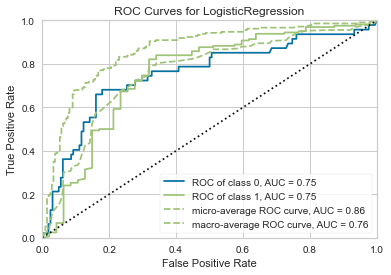

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [2688]:
from yellowbrick.classifier import ROCAUC
# classes=['Good','Fair','Poor']
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

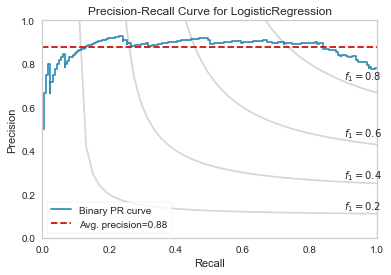

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [2689]:
from yellowbrick.classifier import PrecisionRecallCurve
# classes=['Good','Fair','Poor'],
# colors=["Green", "Yellow", "Red"],
viz = PrecisionRecallCurve(
    model,
    iso_f1_curves=True,
    per_class=True,
    micro=False
)

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

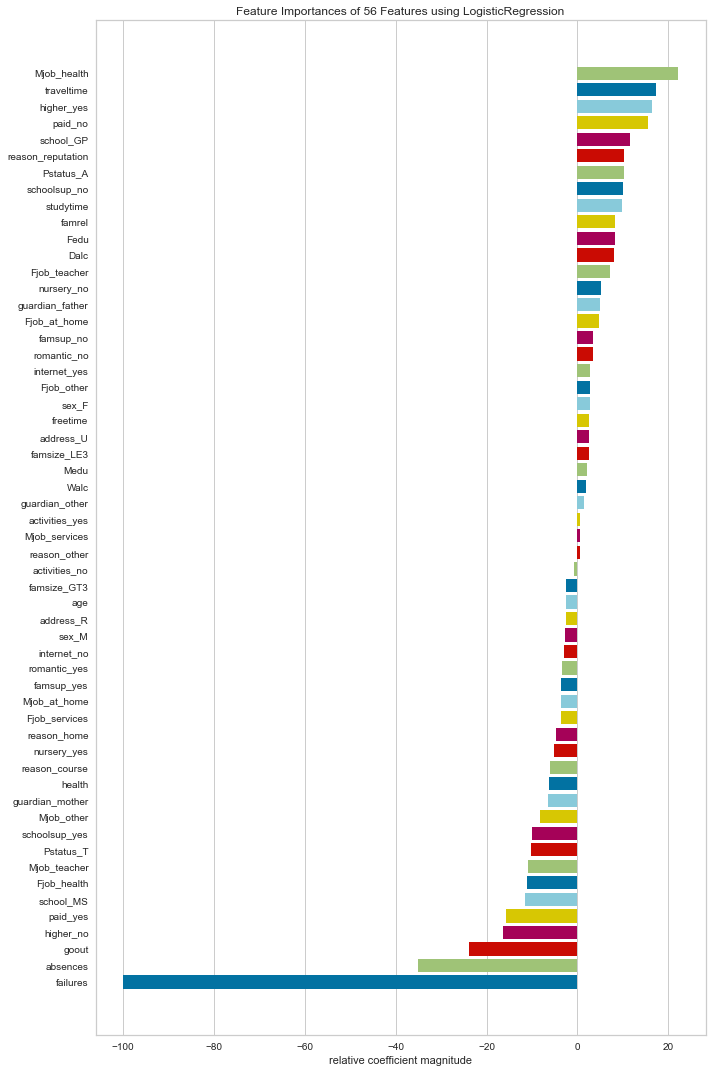

<AxesSubplot:title={'center':'Feature Importances of 56 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [2690]:
from yellowbrick.model_selection import FeatureImportances
plt.figure(figsize=(10,15))
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()